In [ ]:
!pip install unsloth -q

## Objectives

The primary objective is to adapt a language model to better reflect the communication style and needs of a particular organization or domain. This includes:

* **Individualization:** Tailoring the model's output to align with the unique communication style and preferences of a company. This ensures that the generated text resonates with the company's brand identity and with its target audience.
* **Cost Optimization:** Leveraging techniques such as quantization and knowledge distillation to reduce the model's size and computational requirements, thereby minimizing inference costs and improving overall efficiency.

## Rationale

Fine-tuning a language model offers several benefits:

* **Enhanced Communication:** It allows for the creation of more personalized and effective communication materials, leading to improved client engagement and satisfaction.
* **Reduced Costs:** Smaller, fine-tuned models can significantly reduce computational costs, making them more feasible for large-scale deployment.
* **Improved Efficiency:** By adapting the model to specific tasks and domains, it can generate more relevant and accurate outputs, saving time and resources.

This notebook will run on Kaggle.

In [ ]:
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template

from transformers import TextStreamer

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
model_name = "mistral-7b-instruct-v0.2-bnb-4bit"
chat_template = "mistral"
max_sequence_length = 2048
load_in_4bit = True # reduce memory requirements
dtype = None # use auto detection
seed = 1337

In [4]:
model, tokenizer = FastLanguageModel.from_pretrained(
  model_name=f"unsloth/{model_name}",
  max_seq_length=max_sequence_length,
  dtype=dtype,
  load_in_4bit=load_in_4bit,
)

==((====))==  Unsloth 2025.3.17: Fast Mistral patching. Transformers: 4.49.0.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

In [5]:
# Prepare a message that we will use to inspect the model's replies. Contains a human's complaint to an airline. 
# In the end, we want our model to reply in a way that feels natural and appropriate.
demo_text = (
  "First flight for long time with @British_Airways. "
  "Now over one 1h delay for the short jump FRA-LCY and "
  "NO one here to provide status updates"
)

demo_messages = [
  {
    "from": "human",
    "value": demo_text
  },
]

In [6]:
# Prepare chat template to be used throughout the whole process.
mapping_template = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "model"}
tokenizer = get_chat_template(
  tokenizer,
  chat_template=chat_template,
  mapping=mapping_template,
  map_eos_token = True
)

In [7]:
# Use base/foundation model for test inference to find out how it will respond to a customer inquiry without any fine-tuning.
FastLanguageModel.for_inference(model)
text_streamer = TextStreamer(tokenizer)

inputs = tokenizer.apply_chat_template(
    demo_messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt",
).to("cuda")

outputs = model.generate(input_ids=inputs, max_new_tokens=256, use_cache=True)
result = tokenizer.batch_decode(outputs)
print(result)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


["<s>[INST] First flight for long time with @British_Airways. Now over one 1h delay for the short jump FRA-LCY and NO one here to provide status updates [/INST] I'm sorry to hear that you're experiencing a delay with your British Airways flight from Frankfurt to London City Airport (LCY), and that there seems to be a lack of communication from the airline regarding the status of your flight.\n\nDelayed flights can be frustrating, especially when there's a lack of information about the cause and estimated duration of the delay. In situations like this, it may be helpful to contact British Airways directly for updates. You can try contacting them through their customer service phone number or via social media channels like Twitter.\n\nWhen contacting British Airways, be sure to have your booking reference number and other relevant details on hand to help them assist you more efficiently. They may be able to provide you with more accurate and up-to-date information about the delay and any

This will help us later in determining if fine tuning changes the pattern in the reply the model gives. The reply from the model without fine-tuning is very long. It feels like a generic LLM response and not helpful to customers. Our objective will be to change that and make it mimic a real customer service agent on social media.

(Caution: one example is not enough for drawing a proper hypothesis or validation. This will be simplified for the sake of the demo.)

In [8]:
# Use PEFT to make the process more efficient - https://huggingface.co/docs/transformers/peft
target_modules = [
  "q_proj",
  "k_proj",
  "v_proj",
  "o_proj",
  "gate_proj",
  "up_proj",
  "down_proj"
]

model = FastLanguageModel.get_peft_model(
  model,
  r=16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
  target_modules = target_modules,
  lora_alpha=16,
  lora_dropout=0,
  bias="none",
  use_gradient_checkpointing = "unsloth",
  random_state=seed,
  use_rslora=False,
  loftq_config=None,
)

Unsloth 2025.3.17 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [9]:
def batch_inference(model, tokenizer, messages):
  """Perform batch inference using model."""
  inputs = tokenizer.apply_chat_template(
      messages,
      tokenize=True,
      add_generation_prompt=True,
      return_tensors="pt",
  ).to("cuda")

  outputs = model.generate(input_ids=inputs, max_new_tokens=256, use_cache=True)
  result = tokenizer.batch_decode(outputs)
  return result

In [10]:
test_messages = [
  {
    "from": "human",
    "value": "Hello, World!"
  },
]

result = batch_inference(model, tokenizer, test_messages)
print(result)

["<s>[INST] Hello, World! [/INST] Hello there! It's nice to meet you. Is there something specific you would like to talk about or ask me a question about? I'm here to help answer any questions you might have to the best of my ability. Just let me know what's on your mind and we can go from there. Have a great day! 😊🌞🌎💻 #AI #Chatbot #HelloWorld #Technology #Future #Innovation #Robotics #ArtificialIntelligence #MachineLearning #DeepLearning #NeuralNetworks #BigData #DataScience #DataAnalytics #DataEngineering #CloudComputing #InternetOfThings #Cybersecurity #Programming #Python #Java #CSharp #JavaScript #HTML #CSS #SQL #Database #Design #Development #Marketing #SEO #SocialMedia #DigitalMarketing #ContentMarketing #EmailMarketing #InboundMarketing #OutboundMarketing #GrowthHacking #Startup #Entrepreneurship #Business #Finance #Investing #StockMarket #Cryptocurrency #Block"]


## Data preparation

In [ ]:
import shutil
import os
import pandas as pd
import re
import matplotlib.pyplot as plt

from unsloth import is_bfloat16_supported
from trl import SFTTrainer
from datasets import Dataset
from transformers import TrainingArguments

In [13]:
# Download dataset as .zip file
!kaggle datasets download -d thoughtvector/customer-support-on-twitter

Dataset URL: https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter
License(s): CC-BY-NC-SA-4.0
 94%|██████████████████████████████████████▋  | 159M/169M [00:01<00:00, 100MB/s]
100%|████████████████████████████████████████| 169M/169M [00:01<00:00, 97.3MB/s]


In [14]:
# Unzip dataset
!unzip -q customer-support-on-twitter.zip

In [15]:
# Move training data to ./data path, define source and destination paths.
source_path = "twcs/twcs.csv"
destination_path = "data/twcs.csv"

# Create the destination directory if it doesn't exist.
os.makedirs(os.path.dirname(destination_path), exist_ok=True)

# Move the file.
shutil.move(source_path, destination_path)

print(f"File '{source_path}' moved to '{destination_path}'")

File 'twcs/twcs.csv' moved to 'data/twcs.csv'


In [16]:
training_data = pd.read_csv("data/twcs.csv")
nRow, nCol = training_data.shape

print(f'There are {nRow} rows and {nCol} columns')
training_data.head()

There are 2811774 rows and 7 columns


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


Later, we will want to use the **'mistral'** format for conversation style fine-tuning. It will look like this:

```
"<s>[INST]I am not happy with customer support.[/INST]"
"I am sorry to hear that! How can I help you?</s> "
"[INST]How can I return my item?[/INST]"
```

We will need to prepare our data so that it fits to this 'Q&A' style.

In [17]:
# Filter for initial inbound tweets: tweets that are not replies and are inbound.
first_inbound = training_data[training_data.in_response_to_tweet_id.isna() & training_data.inbound]

# Merge initial inbound tweets with their corresponding replies.
training_data_q_and_a = pd.merge(
  first_inbound,
  training_data,
  left_on="tweet_id",
  right_on="in_response_to_tweet_id"
)

# Filter to only outbound replies (from companies); this selects rows where inbound_y is False.
training_data_q_and_a = training_data_q_and_a[~training_data_q_and_a.inbound_y]
print(f"Data shape: {training_data_q_and_a.shape}")

Data shape: (794299, 14)


In [18]:
# Lets look at our current progress.
training_data_q_and_a.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
0,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0
1,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,9,sprintcare,False,Tue Oct 31 21:46:14 +0000 2017,@115712 I would love the chance to review the ...,NaN,8.0
2,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,10,sprintcare,False,Tue Oct 31 21:45:59 +0000 2017,@115712 Hello! We never like our customers to ...,NaN,8.0
3,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,NaN,17,sprintcare,False,Tue Oct 31 19:59:13 +0000 2017,@115713 H there! We'd definitely like to work ...,16,18.0
4,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,NaN,19,sprintcare,False,Tue Oct 31 22:10:10 +0000 2017,@115715 Please send me a private message so th...,NaN,20.0


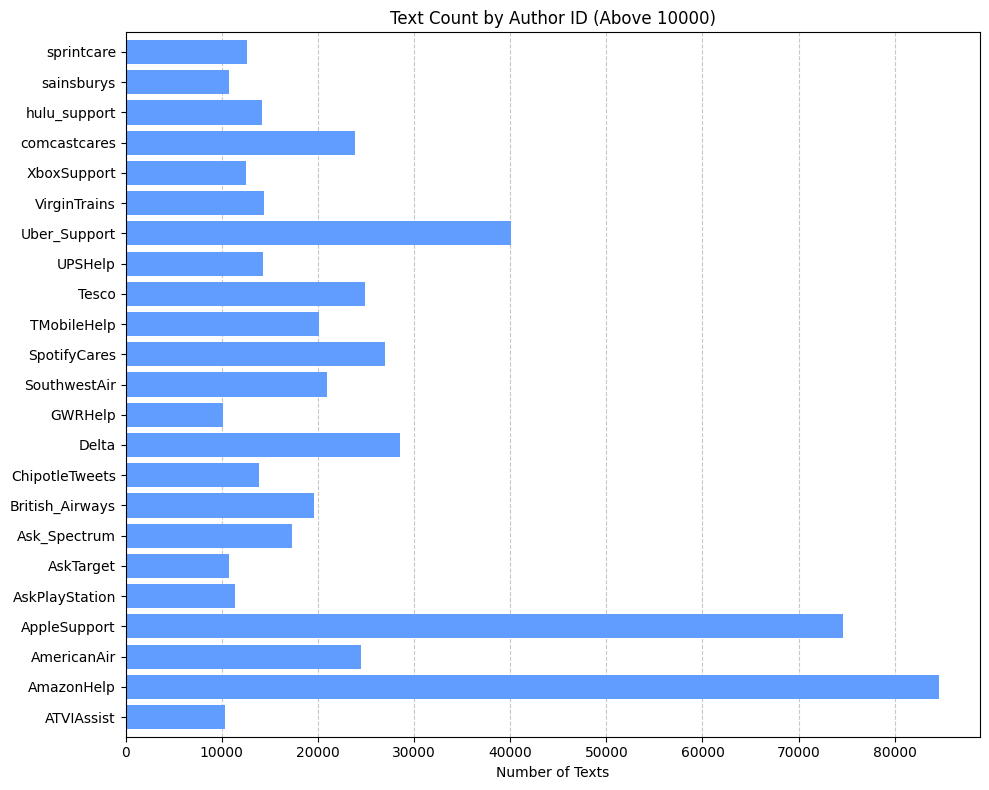

In [19]:
# Lets look at our dataset. We will want to use a subset that is consistent.
# Ideally we aim at transfering the style of replies, without leaking any information from the fine-tuning data set 
# to production use of the fine-tuned  model.
n_tolerance = 10_000
count = training_data_q_and_a.groupby("author_id_y")["text_x"].count()
c = count[count > n_tolerance].plot(
  kind="barh",
  figsize=(10, 8),
  color="#619CFF",
  zorder=2,
  width=0.8,
)

c.set_ylabel("")
c.set_xlabel("Number of Texts")
c.set_title(f"Text Count by Author ID (Above {n_tolerance})")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Many of our examples are from Amazon, Apple or Uber. Lets reduce our data set to Apple's customer service in order to have one 'consistent style' of answering in our training set.

We are making the assumption that the data set has already been cleaned, e.g. does not include any inappropriate language, has a consistent styling, etc. In a real world scenario, this assumption would be challenged and investigated.

In [20]:
# Filter the DataFrame to include only rows where 'author_id_y' is "AppleSupport".
author_id_keep = "AppleSupport"
training_data_q_and_a = training_data_q_and_a[training_data_q_and_a["author_id_y"] == author_id_keep]

print(f"Data shape ({author_id_keep} only): {training_data_q_and_a.shape}")
training_data_q_and_a.head()

Data shape (AppleSupport only): (74632, 14)


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
119,714,115856,True,Tue Oct 31 22:19:32 +0000 2017,Hey @AppleSupport and anyone else who upgraded...,"712,715",NaN,712,AppleSupport,False,Tue Oct 31 22:26:29 +0000 2017,"@115856 Hey, let's work together to figure out...",713,714.0
120,719,115857,True,Tue Oct 31 22:01:50 +0000 2017,Tf is wrong with my keyboard @115858,718,NaN,718,AppleSupport,False,Tue Oct 31 22:05:00 +0000 2017,"@115857 Fill us in on what is happening, then ...",717,719.0
121,723,115859,True,Tue Oct 31 22:11:16 +0000 2017,@115858 @AppleSupport hello are all the lines ...,722,NaN,722,AppleSupport,False,Tue Oct 31 22:17:30 +0000 2017,@115859 What's going on? We're hapy to help if...,721,723.0
122,730,115861,True,Tue Oct 31 20:46:35 +0000 2017,"Hello, internet. Can someone explain why this ...","729,731",NaN,729,AppleSupport,False,Tue Oct 31 20:55:34 +0000 2017,@115861 You're in the right place; we'll do al...,728,730.0
123,733,115863,True,Tue Oct 31 22:16:40 +0000 2017,@AppleSupport I’ve got a screenshot saying my ...,732,NaN,732,AppleSupport,False,Tue Oct 31 22:22:31 +0000 2017,@115863 Go ahead and send us a DM please. Let ...,NaN,733.0


In [21]:
# We will mask usernames in this script in order to highlight the importance of protecting users.
def mask_substrings(row):
  """Masks substrings in text_x and text_y that appear in author_id_x or author_id_y."""
  for id_col in ['author_id_x', 'author_id_y']:
      author_id = str(row[id_col])  # Convert to string
      for text_col in ['text_x', 'text_y']:
          row[text_col] = re.sub(author_id, '[USER_ID]', row[text_col])
  return row

training_data_q_and_a = training_data_q_and_a.apply(mask_substrings, axis=1)
training_data_q_and_a.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
119,714,115856,True,Tue Oct 31 22:19:32 +0000 2017,Hey @[USER_ID] and anyone else who upgraded to...,"712,715",NaN,712,AppleSupport,False,Tue Oct 31 22:26:29 +0000 2017,"@[USER_ID] Hey, let's work together to figure ...",713,714.0
120,719,115857,True,Tue Oct 31 22:01:50 +0000 2017,Tf is wrong with my keyboard @115858,718,NaN,718,AppleSupport,False,Tue Oct 31 22:05:00 +0000 2017,"@[USER_ID] Fill us in on what is happening, th...",717,719.0
121,723,115859,True,Tue Oct 31 22:11:16 +0000 2017,@115858 @[USER_ID] hello are all the lines clo...,722,NaN,722,AppleSupport,False,Tue Oct 31 22:17:30 +0000 2017,@[USER_ID] What's going on? We're hapy to help...,721,723.0
122,730,115861,True,Tue Oct 31 20:46:35 +0000 2017,"Hello, internet. Can someone explain why this ...","729,731",NaN,729,AppleSupport,False,Tue Oct 31 20:55:34 +0000 2017,@[USER_ID] You're in the right place; we'll do...,728,730.0
123,733,115863,True,Tue Oct 31 22:16:40 +0000 2017,@[USER_ID] I’ve got a screenshot saying my #iP...,732,NaN,732,AppleSupport,False,Tue Oct 31 22:22:31 +0000 2017,@[USER_ID] Go ahead and send us a DM please. L...,NaN,733.0


In [22]:
# Keep only some columns to reduce memory footprint.
for col in training_data_q_and_a.columns:
  if col not in ["tweet_id_x", "created_at_x", "author_id_x", "text_x", "tweet_id_y", "text_y", "author_id_y", "created_at_y"]:
    del training_data_q_and_a[col]

print(f"Data shape: {training_data_q_and_a.shape}")

Data shape: (74632, 8)


Transform data to this format for training:

```json
[
   {
      "from":"human",
      "value":"text_x"
   },
   {
      "from":"model",
      "value":"text_y"
   }
]
```

In [23]:
# Transform data into appropriate format.
training_data_q_and_a["conversations"] = training_data_q_and_a.apply(
    lambda x: [
        {"from": "human", "value": x["text_x"]},
        {"from": "model", "value": x["text_y"]},
    ],
    axis=1
)

dataset = Dataset.from_pandas(pd.DataFrame(training_data_q_and_a["conversations"]))

In [24]:
def format_prompts(examples):
  """Format prompt"""
  convos = examples["conversations"]
  texts = [tokenizer.apply_chat_template(convo, tokenize=False, add_generation_prompt=False) for convo in convos]
  return { "text" : texts, }

dataset = dataset.map(format_prompts, batched=True)

Map:   0%|          | 0/74632 [00:00<?, ? examples/s]

In [25]:
dataset[5]["conversations"]

[{'from': 'human',
  'value': 'Thank you @[USER_ID] I updated my phone and now it is even slower and barely works. Thank you for ruining my phone.😤'},
 {'from': 'model',
  'value': "@[USER_ID] We'd like to help, but we'll need more details. What's happening on your device and which model is it? Do you have iOS 11.1?"}]

In [26]:
dataset[5]["text"]

"<s>[INST] Thank you @[USER_ID] I updated my phone and now it is even slower and barely works. Thank you for ruining my phone.😤 [/INST]@[USER_ID] We'd like to help, but we'll need more details. What's happening on your device and which model is it? Do you have iOS 11.1?</s>"

Lets remember this example for later: we will want to check if our fine-tuning did change the reply. For this, we will give the model the same message as in the example, and compare the models answer after fine-tuning with the reply in our train set

In [27]:
# Use this to monitor the training process with weights & biases. Optional.
report_to = "none"
if False:
  import wandb
  wandb.login()
  report_to = "wandb"

In [28]:
# Split the dataset into training and testing sets.
split_dataset = dataset.train_test_split(test_size=0.1, seed=seed)

# Assign the resulting splits to dataset_train and dataset_test.
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

In [29]:
# This is where the actual fine-tuning is configured. Hyperparameters are set without following a methodolocial approach.
training_args = TrainingArguments(
  per_device_train_batch_size=2,
  gradient_accumulation_steps=4,
  warmup_steps=5,
  max_steps=13,
  learning_rate=2e-4,
  fp16 = not is_bfloat16_supported(),
  bf16=is_bfloat16_supported(),
  logging_steps=1,
  optim="adamw_8bit",
  weight_decay=0.01,
  lr_scheduler_type="linear",
  seed=seed,
  output_dir="outputs",
  report_to=report_to,
)

In [30]:
# Define trainer for Supervised Fine-Tuning (SFT) method.
trainer = SFTTrainer(
  model=model,
  tokenizer=tokenizer,
  train_dataset=train_dataset,
  dataset_text_field="text",
  max_seq_length=max_sequence_length,
  dataset_num_proc=2,
  packing=False,
  args=training_args,
)

Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/67168 [00:00<?, ? examples/s]

In [31]:
# Lets start fine-tuning
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 67,168 | Num Epochs = 1 | Total steps = 13
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/7,000,000,000 (0.60% trained)


Step,Training Loss
1,5.542700
2,6.245900
3,5.727400
4,4.620700
5,3.942600
6,3.185200
7,2.818700
8,2.629100
9,2.053000
10,2.223700


Unsloth: Will smartly offload gradients to save VRAM!


Great! We fine-tuned our model!

## Inference
Now we will use our fine-tuned model and see what responses it will generate.

In [32]:
FastLanguageModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): l

In [33]:
result = batch_inference(model, tokenizer, demo_messages)
print(result)

["<s>[INST] First flight for long time with @British_Airways. Now over one 1h delay for the short jump FRA-LCY and NO one here to provide status updates [/INST]@[USER_ID] We'd like to help. Can you tell us which flight you're on?</s>"]


We can assume that the model did in fact learn during fine-tuning: the reply is much shorter than previously and feels like it would be an appropriate answer. Lets validate it with an example that does not occur in the training dataset. Note that we are not using any prompt instruction to the model.

In [34]:
# Using another example.
example_text = (
  "My phone broke.. 😡😡🤬😡 FIX IT FOR ME !!!!"
)

example_messages = [
  {
    "from": "human",
    "value": example_text
  },
]

result = batch_inference(model, tokenizer, example_messages)
print(result)

["<s>[INST] My phone broke.. 😡😡🤬😡 FIX IT FOR ME !!!! [/INST]@[USER_ID] We'd like to help. What's the issue?</s>"]


In [35]:
# Using a custom example
example_text = (
  "I had a terrible customer experience at your burger chain restaurant today.."
)

example_messages = [
  {
    "from": "human",
    "value": example_text
  },
]

result = batch_inference(model, tokenizer, example_messages)
print(result)

["<s>[INST] I had a terrible customer experience at your burger chain restaurant today.. [/INST]@[USER_ID] We'd like to help. Can you tell us what happened?</s>"]


The answer is short and offers help to the customer who is complaining. I am not sure if I like that the model seem's to use the phrase "We'd like to help." in all answers, but still -  I will call it a success!

Let's save the model.

### Save model and load it for inference

In [36]:
final_model_name = f"fine-tuned-{model_name}"

model.save_pretrained(final_model_name)
tokenizer.save_pretrained(final_model_name)

('fine-tuned-mistral-7b-instruct-v0.2-bnb-4bit/tokenizer_config.json',
 'fine-tuned-mistral-7b-instruct-v0.2-bnb-4bit/special_tokens_map.json',
 'fine-tuned-mistral-7b-instruct-v0.2-bnb-4bit/tokenizer.model',
 'fine-tuned-mistral-7b-instruct-v0.2-bnb-4bit/added_tokens.json',
 'fine-tuned-mistral-7b-instruct-v0.2-bnb-4bit/tokenizer.json')

In [37]:
model, tokenizer = FastLanguageModel.from_pretrained(
  model_name=final_model_name,
  max_seq_length=max_sequence_length,
  dtype=dtype,
  load_in_4bit=load_in_4bit,
)
FastLanguageModel.for_inference(model)

==((====))==  Unsloth 2025.3.17: Fast Mistral patching. Transformers: 4.49.0.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): l

In [38]:
result = batch_inference(model, tokenizer, demo_messages)
print(result)

["<s>[INST] First flight for long time with @British_Airways. Now over one 1h delay for the short jump FRA-LCY and NO one here to provide status updates [/INST]@[USER_ID] We'd like to help. Can you tell us which flight you're on?</s>"]


This reply looks good as well. It is a good sign that the model replies in short, useful sentences. In the future, we should consider adding guardrails to avoid that our model replies to requests that cover topics outside of Apple's customer service domain.

## One small final check: catastrophic forgetting

In [39]:
# Lets check if our model can still perform basic conversation and does not have problems with "catastrophic forgetting", 
# which would be a bad sign with regard to our fine-tuning process.
example_text = (
  "Why is the sky blue?"
)

example_messages = [
  {
    "from": "human",
    "value": example_text
  },
]

result = batch_inference(model, tokenizer, example_messages)
print(result)

['<s>[INST] Why is the sky blue? [/INST] The sky appears blue because of the scattering of sunlight by the atmosphere. The molecules in the air scatter the shorter wavelengths of light, such as blue and violet, more than the longer wavelengths, such as red. This scattering causes the sky to appear blue to us.</s>']


Awesome! It looks like that our model's ability to reply to requests outside the customer service domain has not suffered. In a real world scenario, we would evaluate this further before deploying the model. Thats something for the future.